<a href="https://colab.research.google.com/github/RegiTelma/NLP/blob/main/IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.6/215.6 kB 13.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.9 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=3cff29903a2ff87477c6ba25cf4686d100d32ecceddc400bf5a23835621623eb
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [ ]:
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models,layers
import wandb
import random
from wandb.keras import WandbMetricsLogger, WandbEvalCallback



In [ ]:
datasets, info = tfds.load(
    "imdb_reviews/plain_text",
    split=["train","test[:50%]","test[50%:]"], #train,validate,test
    as_supervised=True,
    with_info=True
)
dataset_train_original=datasets[0]
dataset_validate_original=datasets[1]
dataset_test_original=datasets[2]
info

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete5RIS1J/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete5RIS1J/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete5RIS1J/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/plain_text/1.0.0',
    description="""
    Large Movie Review Dataset. This is a dataset for binary sentiment
    classification containing substantially more data than previous benchmark
    datasets. We provide a set of 25,000 highly polar movie reviews for training,
    and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Plain text
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_path=PosixGPath('/tmp/tmpvxm6o543tfds'),
    file_format=tfrecord,
    download_size=80.23 MiB,
    dataset_size=129.83 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
        'text': Text(shape=(), dtype=string),
    }),
    supervised_keys=('text', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=25000, num_shards=1>,
        'train': <SplitInf

In [ ]:
for review,label in dataset_train_original.take(16):
  print(review.numpy().decode("utf-8"))
  print(label.numpy())

This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.
0
I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was co

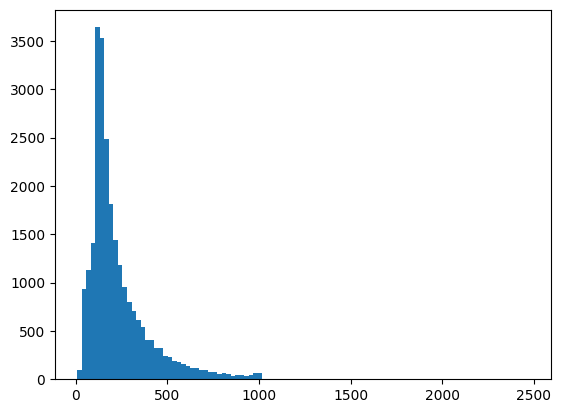

In [ ]:
lengths=[]
for x, _ in dataset_train_original:
  x=x.numpy().decode("utf-8")
  lengths+=[len(x.split())]

plt.hist(lengths,bins=100)
plt.show()

In [ ]:
print("Min",np.min(lengths))
print("Mean",np.mean(lengths))
print("STD",np.std(lengths))
print("Max",np.max(lengths))

Min 10
Mean 233.7872
STD 173.72955740506566
Max 2470


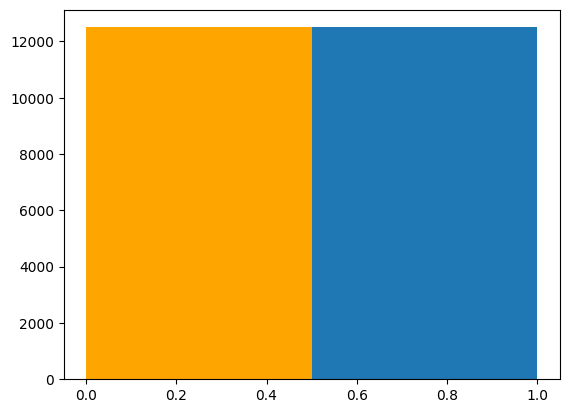

In [ ]:
labels=[]
for _, label in dataset_train_original:
  label=label.numpy()
  labels+= [label]

_,_,patches=plt.hist(labels,bins=2)
patches[0].set_facecolor("orange")
plt.show()

# Bags of words Encoding

In [ ]:
vocabulary_size=10_000

encoder=layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize="lower_and_strip_punctuation", #to remove same words with upper and lower cases(the) as well as punctuations
    split="whitespace",
    output_mode="multi_hot"
)
encoder.adapt(dataset_train_original.map(lambda text,label:text).batch(2048))

In [ ]:
vocabulary= encoder.get_vocabulary()
print(vocabulary[:40])

['[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i', 'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but', 'film', 'on', 'not', 'you', 'are', 'his', 'have', 'he', 'be', 'one', 'its', 'at', 'all', 'by', 'an', 'they', 'from', 'who', 'so', 'like', 'her']


In [ ]:
text="Make AI open again."

text_encoded=encoder(text).numpy()
text_encoded=[str(int(x)) for x in text_encoded]
text_encoded="".join(text_encoded)
print(text_encoded)

1000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000000000100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000000000000000000000000

# Dataset pipelines

In [ ]:
dataset_train=dataset_train_original.cache().shuffle(25_000).batch(128)

dataset_validate=dataset_validate_original.cache().batch(128) # we will not shuffle validation set

dataset_test=dataset_test_original.batch(128)

# ANN

In [ ]:
model=models.Sequential()
model.add(encoder)
model.add(layers.Dense(64,activation="relu"))
model.add(layers.Dense(1,activation="sigmoid")) # not softmax since it always results in 1
model.summary()

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

wandb.init(config={"bs": 12})

history=model.fit(
    dataset_train,
    epochs=3,
    validation_data=dataset_validate,
    callbacks=[WandbMetricsLogger()]
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 10000)            0         
 torization)                                                     
                                                                 
 dense (Dense)               (None, 64)                640064    
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 640,129
Trainable params: 640,129
Non-trainable params: 0
_________________________________________________________________


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch 1/3
196/196 [==============================] - 12s 31ms/step - loss: 0.3351 - accuracy: 0.8625 - val_loss: 0.3155 - val_accuracy: 0.8700
Epoch 2/3
196/196 [==============================] - 3s 17ms/step - loss: 0.1886 - accuracy: 0.9299 - val_loss: 0.3190 - val_accuracy: 0.8740
Epoch 3/3
196/196 [==============================] - 3s 17ms/step - loss: 0.1423 - accuracy: 0.9473 - val_loss: 0.3673 - val_accuracy: 0.8632


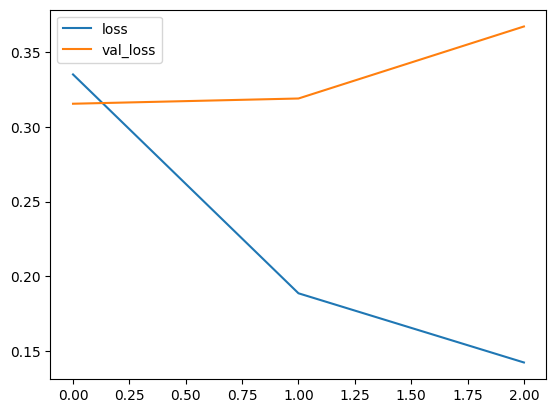

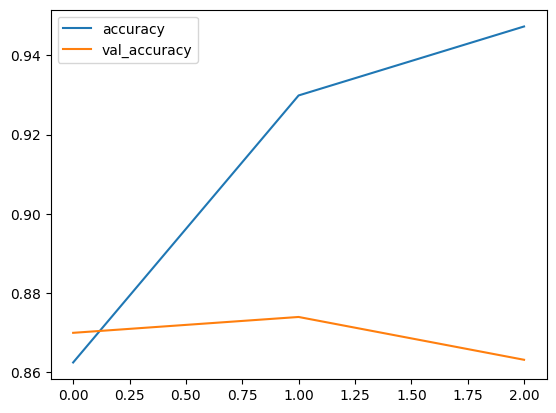

In [ ]:
model.history.history.keys()

def render_history(history):
  assert isinstance(history,dict), f"Expected dict, but got {type(history)}"

  plt.plot(history["loss"],label="loss")
  plt.plot(history["val_loss"],label="val_loss")
  plt.legend()
  plt.show()

  plt.plot(history["accuracy"],label="accuracy")
  plt.plot(history["val_accuracy"],label="val_accuracy")
  plt.legend()
  plt.show()

render_history(model.history.history)

In [ ]:
text="This is an awesome movie,dude. The lighting is perfect. The dialogues are clear"
model.predict([text])[0][0] #2D

1/1 [==============================] - 0s 221ms/step


0.81011224

# Word Embedding

In [ ]:
vocabulary_size=10_000
sequence_length=128

encoder =layers.TextVectorization(
    max_tokens=vocabulary_size,
    output_sequence_length=sequence_length,
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    output_mode="int"
)
encoder.adapt(dataset_train_original.map(lambda text,label:text).batch(2048))

In [ ]:
text="The beginning is a very delicate time.Here comes the year 2023.The known universe is ruled by us"
encoder(text)

<tf.Tensor: shape=(128,), dtype=int64, numpy=
array([   2,  445,    7,    4,   53, 5739,    1,  257,    2,  336,    1,
        617, 2519,    7, 8025,   33,  170,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0])>

In [ ]:
print(encoder.get_vocabulary()[:40])

['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i', 'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but', 'film', 'on', 'not', 'you', 'are', 'his', 'have', 'he', 'be', 'one', 'its', 'at', 'all', 'by', 'an', 'they', 'from', 'who', 'so', 'like']


In [ ]:
print(encoder.get_vocabulary()[9999:])

['hardships']


In [ ]:
print(vocabulary.index("i"))

10


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 128)              0         
 ectorization)                                                   
                                                                 
 embedding_3 (Embedding)     (None, 128, 32)           320000    
                                                                 
 flatten_1 (Flatten)         (None, 4096)              0         
                                                                 
 dense_6 (Dense)             (None, 64)                262208    
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 582,273
Trainable params: 582,273
Non-trainable params: 0
________________________________________________

epoch/accuracy,▁▇█
epoch/epoch,▁▅█
epoch/learning_rate,▁▁▁
epoch/loss,█▃▁
epoch/val_accuracy,▅█▁
epoch/val_loss,▁▁█
epoch/accuracy,0.94728
epoch/epoch,2
epoch/learning_rate,0.001
epoch/loss,0.14232
epoch/val_accuracy,0.8632


Epoch 1/3
196/196 [==============================] - 35s 171ms/step - loss: 0.5241 - accuracy: 0.7148 - val_loss: 0.3845 - val_accuracy: 0.8262
Epoch 2/3
196/196 [==============================] - 15s 76ms/step - loss: 0.2176 - accuracy: 0.9182 - val_loss: 0.4218 - val_accuracy: 0.8175
Epoch 3/3
196/196 [==============================] - 11s 57ms/step - loss: 0.0535 - accuracy: 0.9890 - val_loss: 0.5184 - val_accuracy: 0.8162


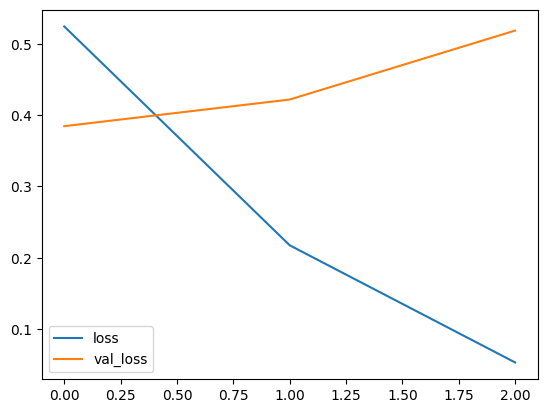

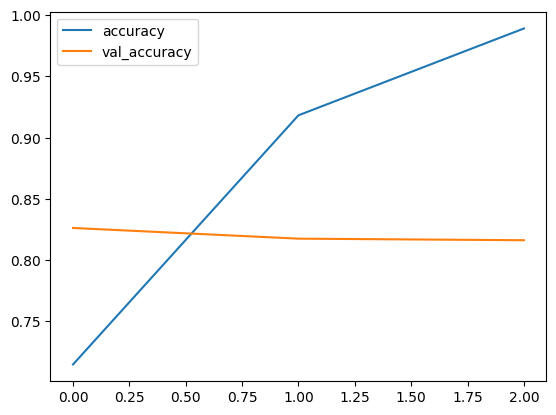

In [ ]:
model=models.Sequential()
model.add(encoder)
model.add(layers.Embedding(input_dim=vocabulary_size,output_dim=32))
model.add(layers.Flatten())
model.add(layers.Dense(64,activation="relu"))
model.add(layers.Dense(1,activation="sigmoid"))
model.summary()

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

wandb.init(config={"bs": 12})

history=model.fit(
    dataset_train,
    epochs=3,
    validation_data=dataset_validate,
    callbacks=[WandbMetricsLogger()]
)
render_history(model.history.history)

In [ ]:
32*10000

320000

# LSTM

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 128)              0         
 ectorization)                                                   
                                                                 
 embedding_8 (Embedding)     (None, 128, 32)           320000    
                                                                 
 lstm_3 (LSTM)               (None, 64)                24832     
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 344,897
Trainable params: 344,897
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
196/196 [==============================] - 28s 131ms/step - loss: 0.5175 - accuracy: 0.7202 - val_loss:

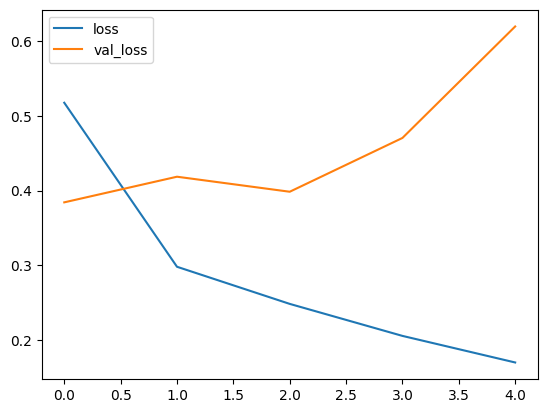

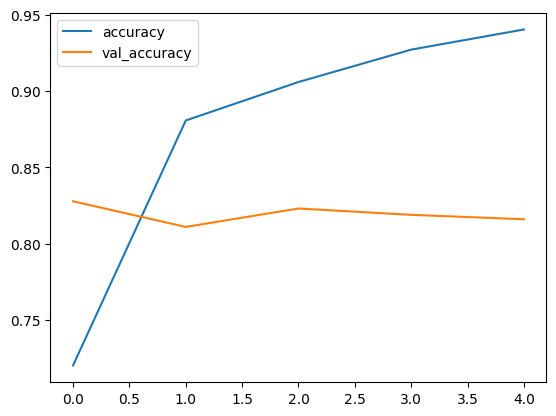

In [ ]:
model=models.Sequential()
model.add(encoder)
model.add(layers.Embedding(input_dim=vocabulary_size,output_dim=32))
model.add(layers.LSTM(64))
model.add(layers.Dense(1,activation="sigmoid"))
model.summary()

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

#wandb.init(config={"bs": 12})

history=model.fit(
    dataset_train,
    epochs=5,
    validation_data=dataset_validate #,
    # callbacks=[WandbMetricsLogger()]
)
render_history(model.history.history)

In [ ]:
model=models.Sequential()
model.add(encoder)
model.add(layers.Embedding(input_dim=vocabulary_size,output_dim=32))
model.add(layers.LSTM(64,return_sequences=True))
model.add(layers.LSTM(128,return_sequences=True))
model.add(layers.LSTM(256))
model.add(layers.Dense(1,activation="sigmoid"))
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 128)              0         
 ectorization)                                                   
                                                                 
 embedding_15 (Embedding)    (None, 128, 32)           320000    
                                                                 
 lstm_16 (LSTM)              (None, 128, 64)           24832     
                                                                 
 lstm_17 (LSTM)              (None, 128, 128)          98816     
                                                                 
 lstm_18 (LSTM)              (None, 256)               394240    
                                                                 
 dense_11 (Dense)            (None, 1)                 257       
                                                     